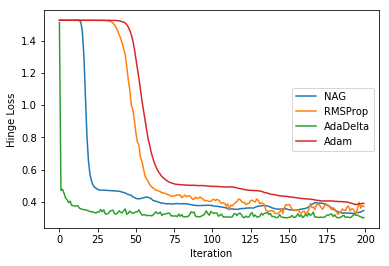

In [3]:
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
import numpy as np
import random

# 读取数据集
mem=Memory('./mycache1')
@mem.cache
def get_data(filename):
    data=load_svmlight_file(filename, n_features=123)
    return data[0], data[1]

# 划分数据集
x_train, y_train = get_data('../data/a9a')
x_test, y_test = get_data('../data/a9a.t')

x_train = x_train.toarray()
x_test = x_test.toarray()

x_train=np.c_[ x_train, np.ones(x_train.shape[0]) ]     # 在样本数据最后添加一整列的1，代替参数b
x_test=np.c_[ x_test, np.ones(x_test.shape[0]) ]     # 在样本数据最后添加一整列的1，代替参数b

# 参数初始化
mu = 0.9      # 动量的加权值
# NAG初始化
w_nag = np.random.rand(124)      # 权重初始化
v = np.zeros(124)    # 动量
yita_nag = 0.01      # 学习率，即梯度的加权值
# RMSP初始化
w_rmsp = np.random.rand(124)
yita_rmsp = 0.01
capital_g_rmsp = np.zeros(124)     
epsilon = 1e-8
# AdaDelta初始化
w_delta = np.random.rand(124)
capital_g_delta = np.random.rand(124)     # 不能全零初始化
gama_delta = 0.95
delta_t = np.random.rand(124)
delta_w = np.zeros(124)
# Adam初始化
w_adam = np.random.rand(124)
yita_adam = 0.1     
beta = 0.9
gama_adam = 0.999
moment = np.random.rand(124)
capital_g_adam = np.random.rand(124)

# 求梯度
def grad(times, w):
    gradw = np.zeros(124)
    for i in range(0, times):
        index = random.randint(0, x_train.shape[0] - 1)
        if y_train[index] * ( np.dot( x_train[index], w ) ) < 1:
            gradw += -1 * ( y_train[index] * x_train[index] )
    return ( w + gradw ) / times     # 返回梯度

# 求准确率
def assess(w):
    right=0.
    for i in range(0, x_test.shape[0]):
        if np.dot( x_test[i] , w ) > 0:
            if ( y_test[i] == +1 ):
                right+=1.
        else:
            if ( y_test[i] == -1 ):
                right+=1.
    return right / x_test.shape[0]

# 计算loss
def getLoss(w):
    label_validate=[]
    for i in range(0, x_test.shape[0]):
        if np.dot( x_test[i], w ) >= 0:
            label_validate.append(1.)
        else:
            label_validate.append(-1.)
    cur=0.
    for i in range(0, x_test.shape[0]):
        cur += max(0, 1.-y_test[i]*label_validate[i])
    return cur / x_test.shape[0]

# 随机梯度下降过程
ranges = range(0, 200)
loss_nag = []
loss_rmsp = []
loss_delta = []
loss_adam = []
accuracy_nag = []
accuracy_rmsp = []
accuracy_delta = []
accuracy_adam = []
precision_nag = []     # 正确预测为正类的数目占所有预测为正类的比例
recall_nag = []    # 正确预测为正类的数目占所有正类的比例
f1_nag = []     # 精确率和召回率的调和均值
precision_rmsp = []     
recall_rmsp = []    
f1_rmsp = []     
for e in ranges:
    # NAG
    gradw = grad(2**4, w_nag - mu * v)
    # 更新w
    v = mu * v + yita_nag * gradw
    w_nag -= v
    # 计算loss
    loss = getLoss(w_nag)
    loss_nag.append(loss)
    # 计算准确率
    accuracy = assess(w_nag)
    accuracy_nag.append(accuracy)
    
    # RMSP
    gradw = grad(2**4, w_rmsp)
    capital_g_rmsp = mu * capital_g_rmsp + (1-mu) * ( gradw * gradw)
    w_rmsp -= ( yita_rmsp / np.sqrt( capital_g_rmsp + epsilon ) ) * gradw
    loss = getLoss(w_rmsp)
    loss_rmsp.append(loss)
    accuracy = assess(w_rmsp)
    accuracy_rmsp.append(accuracy)
   
    # AdaDelta
    gradw = grad(2**10, w_delta)     # 提高样本数目，减少震荡
    capital_g_delta = gama_delta * capital_g_delta + (1-gama_delta) * gradw * gradw
    delta_w = -1 * ( np.sqrt(delta_t + epsilon) / np.sqrt(capital_g_delta + epsilon) ) * gradw
    w_delta += delta_w
    delta_t = gama_delta * delta_t + (1-gama_delta) * delta_w * delta_w
    loss = getLoss(w_delta)
    loss_delta.append(loss)
    accuracy = assess(w_delta)
    accuracy_delta.append(accuracy)
    
    # Adam
    gradw = grad(2**4, w_adam)
    moment = beta * moment + (1-beta) * gradw
    capital_g_adam = gama_adam * capital_g_adam + (1-gama_adam) * gradw * gradw
    alpha = yita_adam * ( np.sqrt(1-gama_adam**(e+1) ) / (1-beta**(e+1)) )
    w_adam -= alpha * moment / np.sqrt(capital_g_adam + epsilon)
    loss = getLoss(w_adam)
    loss_adam.append(loss)
    accuracy = assess(w_adam)
    accuracy_adam.append(accuracy)
    
# 可视化实验结果
import matplotlib.pyplot as plt
figure1,=plt.plot(ranges, loss_nag)
figure2,=plt.plot(ranges, loss_rmsp)
figure3,=plt.plot(ranges, loss_delta)
figure4,=plt.plot(ranges, loss_adam)
plt.xlabel('Iteration')
plt.ylabel('Hinge Loss')
plt.legend(handles=[figure1, figure2, figure3, figure4], labels=['NAG', 'RMSProp', 'AdaDelta', 'Adam'], loc='right')
plt.show()

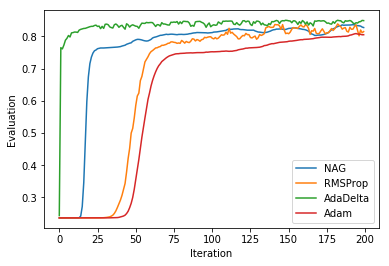

In [5]:
# 可视化实验结果，准确率
import matplotlib.pyplot as plt
figure1,=plt.plot(ranges,accuracy_nag)
figure2,=plt.plot(ranges,accuracy_rmsp)
figure3,=plt.plot(ranges,accuracy_delta)
figure4,=plt.plot(ranges,accuracy_adam)
plt.xlabel('Iteration')
plt.ylabel('Evaluation')
plt.legend(handles=[figure1, figure2, figure3, figure4], labels=['NAG', 'RMSProp', 'AdaDelta','Adam'], loc='best')
plt.show()

In [4]:
print(accuracy_nag[199])
print(accuracy_rmsp[199])
print(accuracy_delta[199])
print(accuracy_adam[199])

0.827590442847491
0.8149990786806707
0.8490878938640133
0.8052945150789264
